# Biopsied breast cell classification

It is estimated that there will be over 200,000 new cases of breast cancer in the United States in 2017. Thankfully, the survival rate is around 90% (https://seer.cancer.gov/statfacts/html/breast.html).

However, it is critical that the cancer be detected as early as possible. A biopsy is often used to gather data about a cell, but it is not immediately clear what features of the biopsy are important for predicting whether not not a cell is benign of malignant. 

In this analysis, I use a data set of 699 biopsies. The goal is to build a model that can predict whether or not a cell is malignant.

In [445]:
import numpy as np
import pandas as pd

from sklearn.decomposition import PCA
from sklearn.preprocessing import Imputer
from sklearn.model_selection import train_test_split

from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc, accuracy_score

from sklearn import linear_model
from sklearn.naive_bayes import MultinomialNB

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Load and clean the data

In [328]:
features =  ['Clump Thickness', 'Size Uniformity', 'Shape Uniformity', 'Marginal Adhesion',
             'Cell Size', 'Bare Nuclei', 'Bland Chromatin','Normal Nucleoli', 'Mitoses']

cols = ['code'] +  features + ['class']

# Load in the dataframe, NA values are marked as '?' in the csv file
df = pd.read_csv('breast-cancer-wisconsin.csv', names=cols, na_values='?')

In [458]:
# ROC curve computation expects class to be binary, so change 2,4 to 0,1

df.loc[df['class'] == 2, 'class'] = 0
df.loc[df['class'] == 4, 'class'] = 1

# Display data frame
df.head()

,code,Clump Thickness,Size Uniformity,Shape Uniformity,Marginal Adhesion,Cell Size,Bare Nuclei,Bland Chromatin,Normal Nucleoli,Mitoses,class
0,1000025,5,1,1,1,2,1,3,1,1,0
1,1002945,5,4,4,5,7,10,3,2,1,0
2,1015425,3,1,1,1,2,2,3,1,1,0
3,1016277,6,8,8,1,3,4,3,7,1,0
4,1017023,4,1,1,3,2,1,3,1,1,0


In [330]:
# Check for missing data

if df.isnull().values.any():
    print('There are missing values in the dataset!')


There are missing values in the dataset!


In [331]:
# Replace all missing data with the median column value

fill_NaN = Imputer(missing_values=np.nan, strategy='median', axis=1)
imputed_df = pd.DataFrame(fill_NaN.fit_transform(df))
imputed_df.columns = df.columns
imputed_df.index = df.index

df = imputed_df

# Data exploration

([<matplotlib.axis.XTick at 0x141962290>,
 <a list of 2 Text xticklabel objects>)

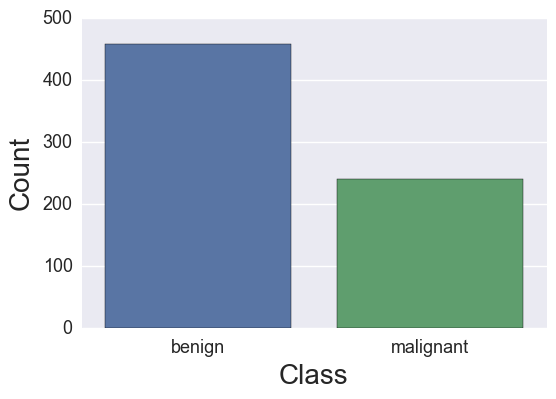

In [578]:
# Plot relative count of benign and malignant cells in the data set 

sns.countplot(df['class'],label="Count")

plt.xlabel('Class', fontsize=20)
plt.ylabel('Count', fontsize=20)
plt.tick_params(axis='x', labelsize=13)
plt.tick_params(axis='y', labelsize=13)
plt.xticks([0, 1], ['benign', 'malignant'])

Most cells in the dataset are benign (about 65%). This is potentially an issue when building a predictive model. In this case I chose not to remove or rebalance the data, since I only have 699 samples.

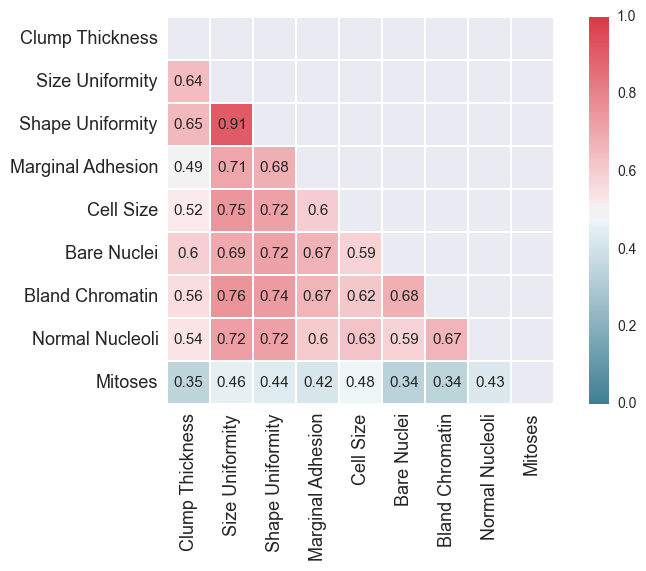

In [553]:
# Compute the correlation matrix

corr = df[features].corr()

mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

f, ax = plt.subplots(figsize=(9, 5))
cmap = sns.diverging_palette(220, 10, as_cmap=True)

sns.heatmap(corr, mask=mask, cmap=cmap, vmin=0, vmax=1,
            square=True, linewidths=.5, annot=True, 
            annot_kws={'size': 11}, ax=ax)

plt.tick_params(axis='x', labelsize=13)
plt.tick_params(axis='y', labelsize=13)

Taking a closer look at the 9 features in the dataset, it is clear that some are strongly correlated with each other. 

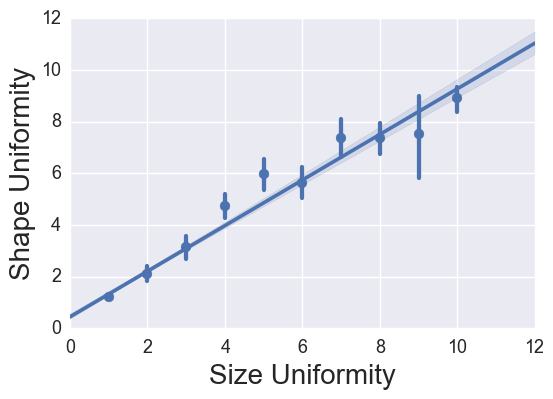

In [434]:
sns.regplot('Size Uniformity', 'Shape Uniformity', data=df, x_estimator=np.mean)

plt.xlim((0,12))
plt.ylim((0,12))

plt.xlabel('Size Uniformity', fontsize=20)
plt.ylabel('Shape Uniformity', fontsize=20)
plt.tick_params(axis='x', labelsize=13)
plt.tick_params(axis='y', labelsize=13)

Shape and size uniformity are very strongly correlated. I chose to keep both in the dataset. However, it is potentially very costly in both time and money for medical examiners to extract information in a biopsy.

Therefore, based on this strong correlation, I would recommend that doctors not extract the shape uniformity when performing future biopsies. 

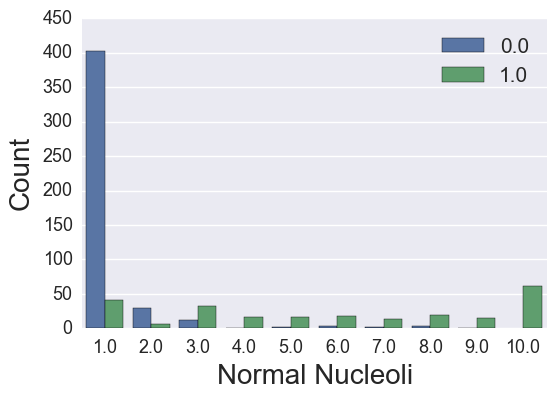

In [579]:
x = 'Normal Nucleoli'
sns.countplot(x=x, data=df, hue='class')

plt.xlabel(x, fontsize=20)
plt.ylabel('Count', fontsize=20)
plt.tick_params(axis='x', labelsize=13)
plt.tick_params(axis='y', labelsize=13)
plt.legend(loc='upper right', shadow=False, scatterpoints=1, fontsize=15)

Looking closer at the individual features, it is apparent that there is a strong separation between malignant and benign on just one feature dimension. 

For example, in the figure above, almost all of the benign cells have a normal nucleoli score of 3 or less. This suggests that a predictive model should be highly accurate at classifying benign vs. malignant. 

# PCA Analysis

It is difficult to visualize all 9 features at once. To take a look at how the data seperate based on class (benign vs. malignant) I performed demensionality deduction via PCA.

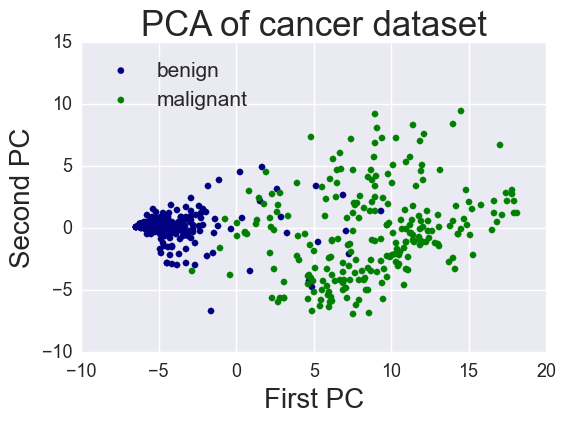

In [463]:
# Plot first two principal components

X = df[features].values
y = df['class'].values
target_names = ['benign', 'malignant']

n_components = 9
pca = PCA(n_components = n_components)
X_r = pca.fit(X).transform(X)

# Plot 
plt.figure()
colors = ['navy', 'green']
lw = 2

for color, i, target_name in zip(colors, [0, 1], target_names):
    plt.scatter(X_r[y == i, 0], X_r[y == i, 1], color=color,
                label=target_name)

plt.legend(loc='upper left', shadow=False, scatterpoints=1, fontsize=15)
plt.title('PCA of cancer dataset', fontsize = 25)
plt.xlabel('First PC', fontsize=20)
plt.ylabel('Second PC', fontsize=20)
plt.tick_params(axis='x', labelsize=13)
plt.tick_params(axis='y', labelsize=13)

From the figure above, it is even more clear that there is a distinct difference between benign and malignant. Even a simple linear discriminator should be able to classify the cells.

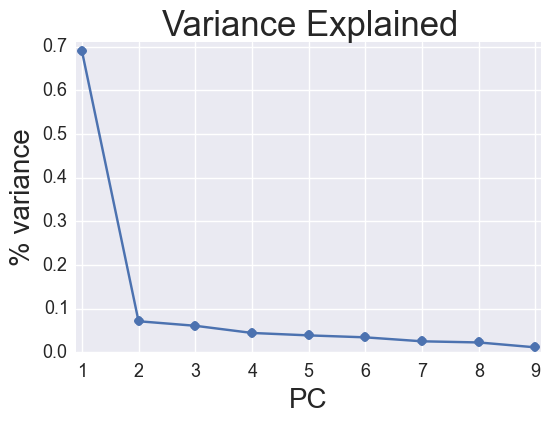

In [580]:
plt.plot(range(1, n_components+1), pca.explained_variance_ratio_, marker='o')

plt.title('Variance Explained', fontsize = 25)

plt.xlim((0.9, 9.1))
plt.ylim((0, 0.71))

plt.xticks(range(1, n_components+1))
plt.xlabel('PC', fontsize=20)
plt.ylabel('% variance', fontsize=20)
plt.tick_params(axis='x', labelsize=13)
plt.tick_params(axis='y', labelsize=13)

A large proportion of the variance (70%) is contained in the first principle component. Below, I plot the data projected down into 1 dimension.

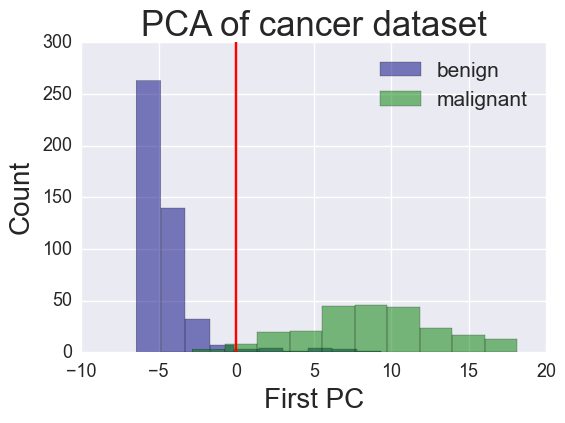

In [581]:
for color, i, target_name in zip(colors, [0, 1], target_names):    
    plt.hist(X_r[y == i, 0], color=color, label=target_name, alpha=0.5)
    
pc0 = X_r[y == 0, 0]
pc1 = X_r[y == 1, 0]

plt.plot([0,0],[0,300], color='r')    

plt.legend(loc='upper right', shadow=False, scatterpoints=1, fontsize=15)
plt.title('PCA of cancer dataset', fontsize = 25)
plt.xlabel('First PC', fontsize=20)
plt.ylabel('Count', fontsize=20)
plt.tick_params(axis='x', labelsize=13)
plt.tick_params(axis='y', labelsize=13)


Even in 1D, the data are well separated. A threshold placed at the red line (where any value above is classified as malignant, and any value below is classifies ad benign) would be very accurate in classifying benign vs. malignant. 

However, even though this simple linear classifier would be very accurate, it might not be the best for the client. A a false positive is bad because it causes an unnessessary burden on the patient (both mentally and financially). However, a false negative is worse, because it means that the cancer was not detected. To look futher into this trade off, I plotted the ROC curve for the simple linear classifier.

In [520]:
# Compute ROC curve

n_0 = len(pc0)
n_1 = len(pc1)

tp = []
fp = []

for c in range(-10, 20):
    tp.append(sum(pc1 >= c)/float(n_1))
    fp.append(sum(pc0 >= c)/float(n_0))

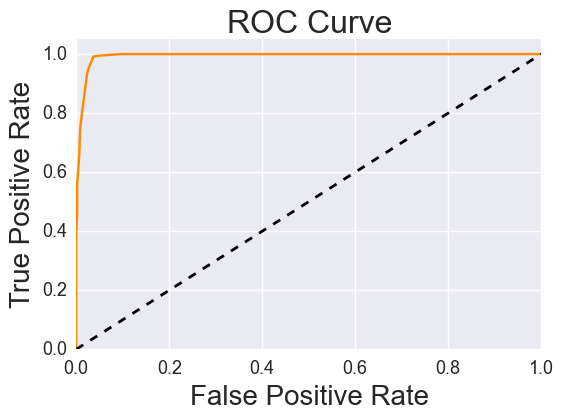

In [521]:
# Plot ROC curve 

plt.plot(fp, tp, color='darkorange')
plt.plot([0, 1], [0, 1], color='black', lw=lw, linestyle='--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=20)
plt.ylabel('True Positive Rate', fontsize=20)
plt.title('ROC Curve', fontsize=23)

plt.tick_params(axis='x', labelsize=13)
plt.tick_params(axis='y', labelsize=13)

The ROC curve is very steep. To get a better sense of the trade off, I zoom into the interesting part of the curve.

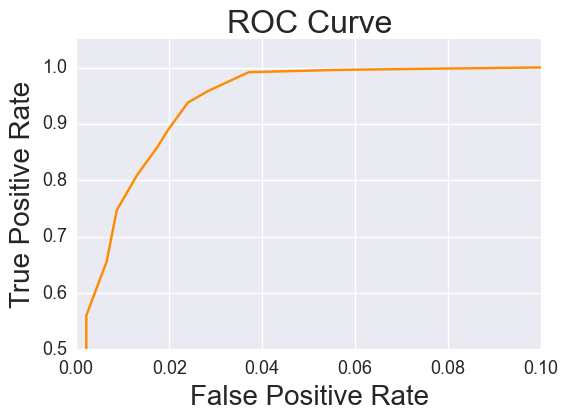

In [522]:
# Zoom into interesting part of the ROC curve

plt.plot(fp, tp, color='darkorange')
plt.plot([0, 1], [0, 1], color='black', lw=lw, linestyle='--')

plt.xlim([0.0, 0.1])
plt.ylim([0.5, 1.05])
plt.xlabel('False Positive Rate', fontsize=20)
plt.ylabel('True Positive Rate', fontsize=20)
plt.title('ROC Curve', fontsize=23)

plt.tick_params(axis='x', labelsize=13)
plt.tick_params(axis='y', labelsize=13)

Here, we see the tade off between true positive and false positive. Decreasing the number of false negatives means increasing the number of false positives. The client would have to decide the ideal trade off between the two.

## PCA summary

The simple linear model shown above is accurate, and can tell us about the trade off between false positives and false negatives. However, it does not tell us anything about the relative importance of the biopsy features. 

This might be important to the client, because biopsies are costly, and it would be useful to know if certain biopsy features are not important when predicting benign vs. malignant.

# Logistic Regression Model

To answer the question of biopsy feature importance, I build a logistic regression model. I chose this model because it is simple, and the model coefficients are easy to interpret.

In [444]:
X = df[features].values
y = df['class'].values

# Verify by printing both the head of the dataframe and first 5 rows of X
print(X[0:5,:])
df.head()

[[  5.   1.   1.   1.   2.   1.   3.   1.   1.]
 [  5.   4.   4.   5.   7.  10.   3.   2.   1.]
 [  3.   1.   1.   1.   2.   2.   3.   1.   1.]
 [  6.   8.   8.   1.   3.   4.   3.   7.   1.]
 [  4.   1.   1.   3.   2.   1.   3.   1.   1.]]


,code,Clump Thickness,Size Uniformity,Shape Uniformity,Marginal Adhesion,Cell Size,Bare Nuclei,Bland Chromatin,Normal Nucleoli,Mitoses,class
0,1000025,5,1,1,1,2,1,3,1,1,0
1,1002945,5,4,4,5,7,10,3,2,1,0
2,1015425,3,1,1,1,2,2,3,1,1,0
3,1016277,6,8,8,1,3,4,3,7,1,0
4,1017023,4,1,1,3,2,1,3,1,1,0


In [535]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

In [536]:
model = linear_model.LogisticRegression()
model.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

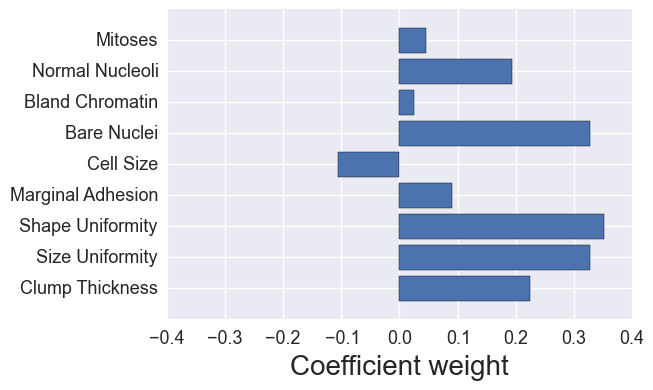

In [537]:
# The coefficients
# print('Coefficients: \n', model.coef_)
plt.barh(range(len(features)), model.coef_[0], align='center')
plt.yticks(range(len(features)), features)
plt.xlim((-0.4, 0.4))
plt.xlabel('Coefficient weight', fontsize=20)
plt.tick_params(axis='x', labelsize=13)
plt.tick_params(axis='y', labelsize=13)

The figure above shows the coefficient weight for all 9 features. Shape uniformity is most important, folloed by size uniformity and normal nucleoli. Bland chromatin and mitoses are the least important factors.

In [577]:
y_prediction = model.predict(X_test)
acc = accuracy_score(y_prediction,y_test)
acc = acc*100 

print('Model accuracy is %.1f percent.' % acc)

Model accuracy is 96.5 percent.


The model is highly accurate, but agian this accuracy is not necessarily what the client is interested in. Below I analyse the trade off between precision and recall.

In [539]:
# Compute ROC curve and ROC area for each class
y_score = model.decision_function(X_test)
fpr, tpr, _ = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)

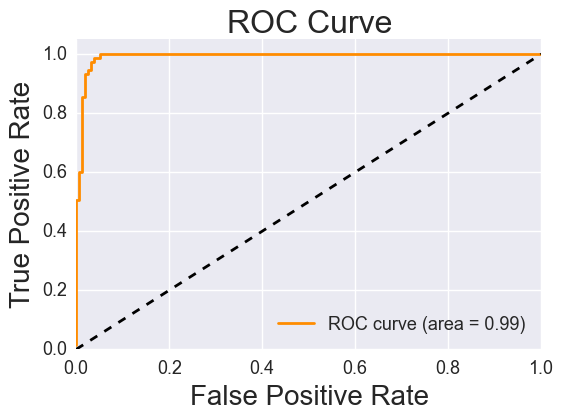

In [540]:
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)

plt.plot([0, 1], [0, 1], color='black', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=20)
plt.ylabel('True Positive Rate', fontsize=20)
plt.title('ROC Curve', fontsize=23)
plt.legend(loc="lower right", fontsize=13)

plt.tick_params(axis='x', labelsize=13)
plt.tick_params(axis='y', labelsize=13)

Like before in the PCA analysis, the ROC curve is very steep. 

In [544]:
# Compute confusion matrix

cnf_matrix = confusion_matrix(y_test, y_prediction)

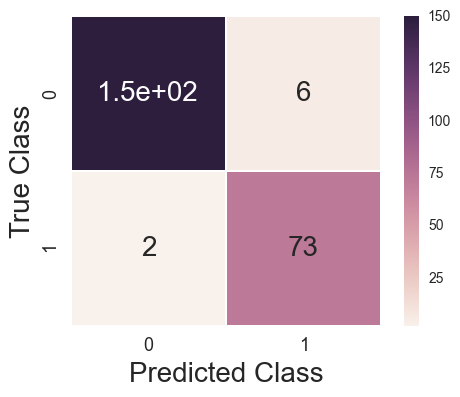

In [565]:
# Plot confusion matrix 

sns.heatmap(cnf_matrix,square=True, linewidths=.5, annot=True, annot_kws={'size': 20})

plt.xlabel('Predicted Class', fontsize=20)
plt.ylabel('True Class', fontsize=20)

plt.tick_params(axis='x', labelsize=13)
plt.tick_params(axis='y', labelsize=13)

To make more sense of the ROC curve, I've plotted the confusion matrix above. We can see that 3 percent (2/75) of the time when the true class was malignant, the model predicted benign. This is clearly bad, because a false negative means that the cancer is not treated.

In [541]:
# Compute precision and recall

precision, recall, _ = precision_recall_curve(y_test, y_score)
average_precision = average_precision_score(y_test, y_score)

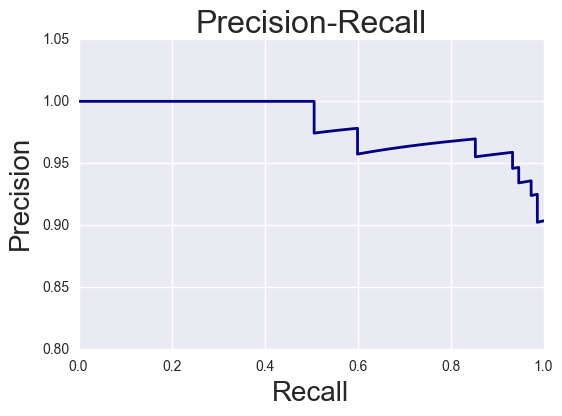

In [566]:
# Plot precision and recall

plt.plot(recall, precision, lw=lw, color='navy')

plt.xlabel('Recall', fontsize=20)
plt.ylabel('Precision', fontsize=20)

plt.ylim([0.8, 1.05])
plt.xlim([0.0, 1.0])

plt.title('Precision-Recall', fontsize=23)

To visualize the trade off, above I've plotted the precision of the model, vs the recall. The client would need to decide the precision rate that is acceptable when predicting malignant cancers.  

## Actionable Insights

I found that cell shape uniformity and cell size uniformity are strongly correlated. Therefore, I would recommend to the client to only collect one when performing biopsies. 

I found that bland chromatin and mitoses contribute relatively little to the overall prediction. Because of this, I would recommend that the client not collect these two measures when performing biopsies.